In [104]:
%matplotlib inline
import pandas as ppd
import numpy as np
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import datetime as dt

# Load data

Use the data from the files for now instead of calling API.

In [25]:
tmdb_movies = pd.read_json("drv_tmdb_movie_details.json")
imdb_movies = pd.read_json("drv_imdb_movie_details.json")

In [26]:
# tmdb
# max id
print(max(tmdb_movies['id']))

# rows
print(len(tmdb_movies.index))

10010
925


In [27]:
# imdb
# rows
print(len(imdb_movies.index))

100


# Format data

# Movie genre classification

We need to address the following problems before we do movie genre classification:

1. TMDB and IMDB have different movie genre list and this can create issues for prediction. TMDB should have a smaller list than IMDB.
2. We can check if the genre classification are similiar for IMDB and TMDB by the following:
    look at percentage breakdown of each genre. If the results are significantly different amonng the two databases, we will have to explore what causes the difference.
2. A movie can have more than 1 genre. The data from TMDB and IMDB will not indicate which one is the main genre if there is more than 1 genre. However, when we do movie genre prediction, we may only want our reponse to be 1 genre. 
    1. If we do fuzzy classification, we can use see if the results align with multiple genres.
    2. We can also treat it as binary classification problem for each genre, ex. seperate problems of if a movie is Horror and if a movie is Romance. But if the movie number of a genre is too big or too small, the one-vs-all approach may not be good.

Below are useful resources:
* [IMDB genre guide](http://www.imdb.com/help/search?domain=helpdesk_faq&index=2&file=genres)


In [28]:
def get_genre(tmdb_movies ,key):
    tmdb_genre = tmdb_movies[key].tolist()
    tmdb_genre_set = set()
    for g in tmdb_genre:
        tmdb_genre_set = tmdb_genre_set.union(set(g))
    tmdb_genre = list(tmdb_genre_set)
    tmdb_genre.sort()
    return(tmdb_genre)

In [29]:
def is_genre (row, column_name, genre):
    """check if that movie is in this genre as a movie can have more than 1 genre"""
    if genre in row[column_name] :
        return True
    else:
        return False

In [30]:
# as the genre is in list format in the data field, we cannot utilize any data frame function and it is very hard to compare
# thus, we have to transform data set 

def add_genre_columns(tmdb_movies, genre_column):
    tmdb_genre = get_genre(tmdb_movies,genre_column)
    tmdb_movies[u'genre_num'] = tmdb_movies.apply(lambda row: len(row[genre_column]), axis=1)

    for g in tmdb_genre: 
        tmdb_movies[g] = tmdb_movies.apply(lambda row: is_genre(row,genre_column,g), axis=1)



In [31]:
tmdb_genre = get_genre(tmdb_movies,u'genres')
tmdb_movies[u'genre_num'] = tmdb_movies.apply(lambda row: len(row[u'genres']), axis=1)

for g in tmdb_genre: 
    tmdb_movies[g] = tmdb_movies.apply(lambda row: is_genre(row,u'genres',g), axis=1)

In [32]:
np.mean(tmdb_movies[u'genre_num'])

2.667027027027027

In [33]:
tmdb_genre_df = tmdb_movies[tmdb_genre].apply(pd.value_counts).transpose()
tmdb_genre_df

,False,True
Action,602,323
Adventure,667,258
Animation,863,62
Comedy,587,338
Crime,762,163
Documentary,920,5
Drama,707,218
Family,815,110
Fantasy,790,135
Foreign,914,11


In [34]:
imdb_genre = get_genre(imdb_movies,u'genre')
imdb_movies[u'genre_num'] = imdb_movies.apply(lambda row: len(row[u'genre']), axis=1)

for g in imdb_genre: 
    imdb_movies[g] = imdb_movies.apply(lambda row: is_genre(row,u'genre',g), axis=1)

In [35]:
imdb_genre_df = imdb_movies[imdb_genre].apply(pd.value_counts).transpose()
imdb_genre_df

,False,True
Action,56,44
Adventure,56,44
Animation,88,12
Biography,96,4
Comedy,80,20
Crime,80,20
Documentary,96,4
Drama,68,32
Family,96,4
Fantasy,84,16


In [36]:
np.mean(imdb_movies[u'genre_num'])

2.96

## Observations on genre list

1. The genre lists between IMDB and TMDB are very similiar so far. Perhaps it is because we have extracted the same movie.
2. A movie has 3 genres on average.
3. Half of the genres(ex. Documentary and War) have only a few movies. One-vs-all approach may not be good.

## EDA by Ai

In [37]:
print "Dimension of TMDB dataset:" ,tmdb_movies.shape

Dimension of TMDB dataset: (925, 45)


In [38]:
print "Dimension of IMDB dataset:" ,imdb_movies.shape

Dimension of IMDB dataset: (100, 106)


In [58]:
tmdb_movies.columns.values

array([u'adult', u'backdrop_path', u'belongs_to_collection', u'budget',
       u'genres', u'homepage', u'id', u'imdb_id', u'original_language',
       u'original_title', u'overview', u'popularity', u'poster_path',
       u'production_companies', u'production_countries', u'release_date',
       u'revenue', u'runtime', u'spoken_languages', u'status', u'tagline',
       u'title', u'video', u'vote_average', u'vote_count', u'genre_num',
       u'Action', u'Adventure', u'Animation', u'Comedy', u'Crime',
       u'Documentary', u'Drama', u'Family', u'Fantasy', u'Foreign',
       u'History', u'Horror', u'Music', u'Mystery', u'Romance',
       u'Science Fiction', u'Thriller', u'War', u'Western'], dtype=object)

In [17]:
tmdb_movies.head(5)

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,Thriller,War,Western
10003,False,/lJnl8xIhplfzUBtlJLsWBwvXVBj.jpg,The Saint Collection,68000000,"[Thriller, Action, Romance, Science Fiction, A...",,10003,tt0120053,en,The Saint,...,False,False,False,False,False,True,True,True,False,False
10005,False,/u7IzK6tISpsSuNkWMowl17gSA4e.jpg,Behind Enemy Lines Collection,0,"[Action, Adventure, Thriller]",http://www.foxhome.com/behindenemylinesiiaxiso...,10005,tt0497329,en,Behind Enemy Lines II: Axis of Evil,...,False,False,False,False,False,False,False,True,False,False
10007,False,/l9fdcaqaQQLE2K8cYwfoIPXi0i7.jpg,See No Evil Collection,8000000,"[Horror, Thriller]",,10007,tt0437179,en,See No Evil,...,False,False,True,False,False,False,False,True,False,False
10009,False,/fAzT4AboZXP2Sj3zE2HcQ7qjMi.jpg,Brother Bear Collection,100000000,"[Adventure, Animation, Family]",http://movies.disney.com/brother-bear,10009,tt0328880,en,Brother Bear,...,False,False,False,False,False,False,False,False,False,False
10010,False,/zhMiJmPuX2o2bbXWWZNUgVbw3OM.jpg,Brother Bear Collection,0,"[Adventure, Animation, Family]",http://movies.disney.com/brother-bear-2,10010,tt0465925,en,Brother Bear 2,...,False,False,False,False,False,False,False,False,False,False


In [18]:
imdb_movies.head(5)

,actors,actresses,aka,also known as,amazon review,art direction by,casting,casting by,certificate,certification,...,Fantasy,Horror,Music,Musical,Romance,Sci-Fi,Short,Sport,Thriller,War
0,"[{u'personID': u'0000552', u'name': u'Eddie Mu...","[{u'personID': u'0000552', u'name': u'Eddie Mu...","[Un detective suelto en Hollywood::Argentina, ...","[Un detective suelto en Hollywood::Argentina, ...",NaN,"[{u'personID': u'0613468', u'name': u'James J....","[{u'personID': u'0799557', u'name': u'Margery ...","[{u'personID': u'0799557', u'name': u'Margery ...","[Argentina:16, Australia:M, Brazil:12, Canada:...","[Argentina:16, Australia:M, Brazil:12, Canada:...",...,False,False,False,False,False,False,False,False,False,False
1,"[{u'personID': u'0000160', u'name': u'Ethan Ha...","[{u'personID': u'0000160', u'name': u'Ethan Ha...","[Antes del atardecer::Argentina, International...","[Antes del atardecer::Argentina, International...",NaN,None,None,None,"[Argentina:Atp, Australia:M, Austria:0, Brazil...","[Argentina:Atp, Australia:M, Austria:0, Brazil...",...,False,False,False,False,True,False,False,False,False,False
10,"[{u'personID': u'0000136', u'name': u'Johnny D...","[{u'personID': u'0000136', u'name': u'Johnny D...","[P.O.T.C. 2::USA (promotional abbreviation), P...","[P.O.T.C. 2::USA (promotional abbreviation), P...",NaN,"[{u'personID': u'0188692', u'name': u'Bruce Cr...","[{u'personID': u'0150522', u'name': u'Denise C...","[{u'personID': u'0150522', u'name': u'Denise C...","[Argentina:13, Australia:M, Brazil:12, Canada:...","[Argentina:13, Australia:M, Brazil:12, Canada:...",...,True,False,False,False,False,False,False,False,False,False
11,"[{u'personID': u'0000235', u'name': u'Uma Thur...","[{u'personID': u'0000235', u'name': u'Uma Thur...","[Kill Bill::USA (informal short title), Kill B...","[Kill Bill::USA (informal short title), Kill B...",NaN,"[{u'personID': u'0103011', u'name': u'Daniel B...","[{u'personID': u'0535338', u'name': u'Koko Mae...","[{u'personID': u'0535338', u'name': u'Koko Mae...","[Argentina:16, Australia:R18+, Brazil:18, Cana...","[Argentina:16, Australia:R18+, Brazil:18, Cana...",...,False,False,False,False,False,False,False,False,True,False
12,"[{u'personID': u'0671231', u'name': u'Matti Pe...","[{u'personID': u'0671231', u'name': u'Matti Pe...",[Shadows in Paradise::International (English t...,[Shadows in Paradise::International (English t...,NaN,"[{u'personID': u'0383991', u'name': u'Pertti H...",None,None,"[Finland:S, Iceland:L, Singapore:PG, UK:12::(v...","[Finland:S, Iceland:L, Singapore:PG, UK:12::(v...",...,False,False,False,False,True,False,False,False,False,False


## 1. TMDB

### (1) Numeric Features

In [39]:
numeric=tmdb_movies.select_dtypes(include = ['float64', 'int64'])
numeric.columns.values
numeric.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,genre_num
count,9.250000e+02,925.000000,925.000000,9.250000e+02,925.000000,925.000000,925.000000,925.000000
mean,2.590425e+07,4357.087568,1.615912,1.158939e+08,103.463784,6.015568,651.581622,2.667027
std,4.402761e+07,3571.332019,1.615756,1.978777e+08,23.359000,1.519119,1091.690985,1.212063
min,0.000000e+00,2.000000,0.000001,0.000000e+00,21.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,927.000000,0.414647,0.000000e+00,90.000000,5.600000,32.000000,2.000000
50%,5.000000e+06,3124.000000,1.257570,2.550451e+07,100.000000,6.300000,241.000000,3.000000
75%,3.000000e+07,8467.000000,2.193749,1.417747e+08,115.000000,6.900000,720.000000,3.000000
max,3.800000e+08,10010.000000,13.130939,1.118889e+09,292.000000,9.000000,9653.000000,7.000000


In [40]:
#Delete id and genre_num, which are not original features
numeric=numeric.drop(numeric.columns[[1,7]], axis=1)
print "Number of numerical features:", numeric.shape[1]
numeric.describe()

Number of numerical features: 6


,budget,popularity,revenue,runtime,vote_average,vote_count
count,9.250000e+02,925.000000,9.250000e+02,925.000000,925.000000,925.000000
mean,2.590425e+07,1.615912,1.158939e+08,103.463784,6.015568,651.581622
std,4.402761e+07,1.615756,1.978777e+08,23.359000,1.519119,1091.690985
min,0.000000e+00,0.000001,0.000000e+00,21.000000,0.000000,0.000000
25%,0.000000e+00,0.414647,0.000000e+00,90.000000,5.600000,32.000000
50%,5.000000e+06,1.257570,2.550451e+07,100.000000,6.300000,241.000000
75%,3.000000e+07,2.193749,1.417747e+08,115.000000,6.900000,720.000000
max,3.800000e+08,13.130939,1.118889e+09,292.000000,9.000000,9653.000000


### Check Missing Value

In [41]:
n_missing=[]
p=[]
for col in numeric:
    n_missing.append(numeric[col].isnull().values.sum())
    p.append((numeric[col].isnull().values.sum())/float(numeric.shape[0]))
missing=pd.DataFrame({'Features': numeric.columns.values, 'Missing':n_missing, 'Missing Precentage':p })
print "Number of missing values"
missing[missing['Missing']!=0]

Number of missing values


,Features,Missing,Missing Precentage


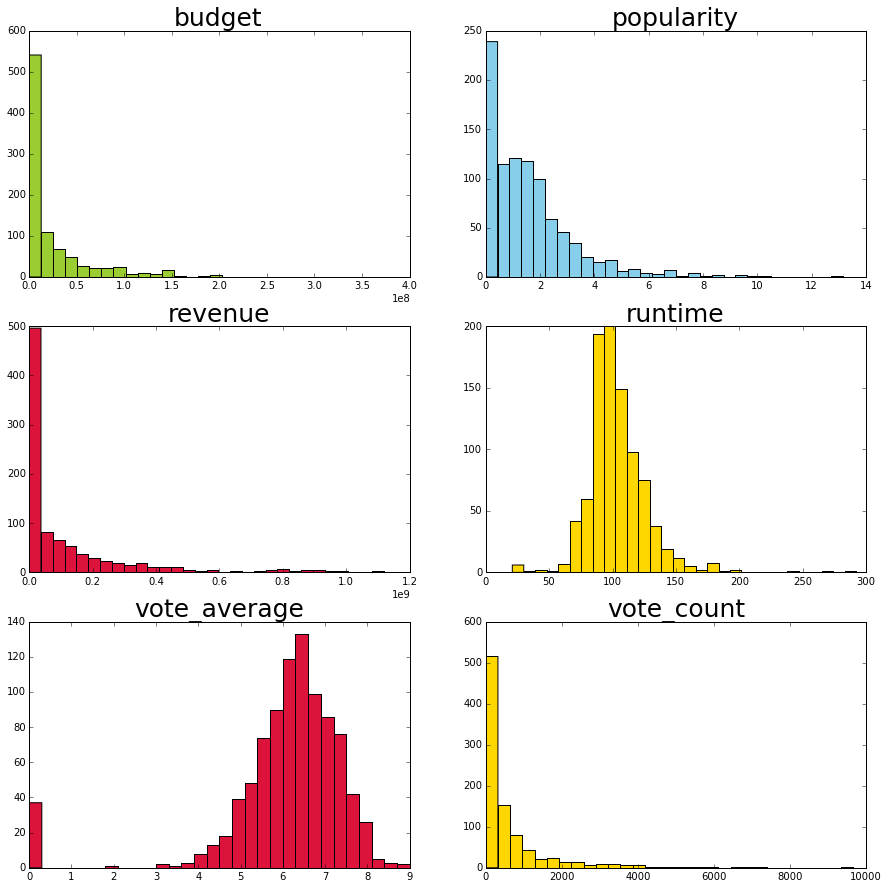

In [49]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(15, 15))
ax1.set_title('budget',fontsize=25)
ax1=ax1.hist(numeric['budget'].values,color='yellowgreen',bins=30)
ax2.set_title('popularity',fontsize=25)
ax2=ax2.hist(numeric['popularity'].values,color='skyblue', bins=30)
ax3.set_title('revenue',fontsize=25)
ax3=ax3.hist(numeric['revenue'].values,color='crimson', bins=30)
ax4.set_title('runtime',fontsize=25)
ax4=ax4.hist(numeric['runtime'].values, color='gold',bins=30)
ax5.set_title('vote_average',fontsize=25)
ax5=ax5.hist(numeric['vote_average'].values,color='crimson', bins=30)
ax6.set_title('vote_count',fontsize=25)
ax6=ax6.hist(numeric['vote_count'].values, color='gold',bins=30)
plt.show()

### Correlation

In [50]:
corr = numeric.corr()

In [51]:
corr

,budget,popularity,revenue,runtime,vote_average,vote_count
budget,1.000000,0.586661,0.763849,0.369637,0.089803,0.602550
popularity,0.586661,1.000000,0.712083,0.369341,0.346313,0.838055
revenue,0.763849,0.712083,1.000000,0.376663,0.206086,0.792706
runtime,0.369637,0.369341,0.376663,1.000000,0.239471,0.390160
vote_average,0.089803,0.346313,0.206086,0.239471,1.000000,0.309466
vote_count,0.602550,0.838055,0.792706,0.390160,0.309466,1.000000


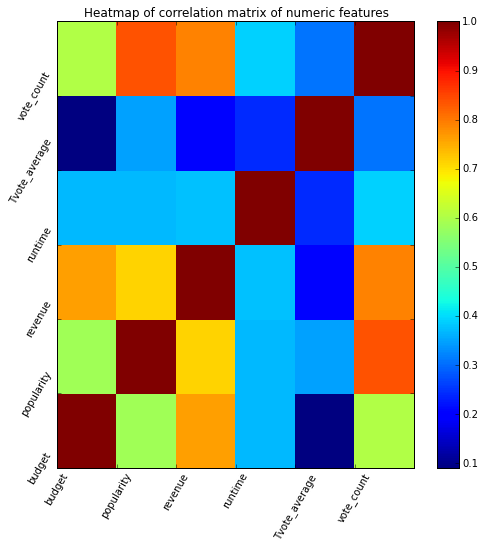

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.pcolor(corr)
ax.set_title('Heatmap of correlation matrix of numeric features')
plt.colorbar(ax.pcolor(corr))
ax.set_xticklabels(( 'budget', 'popularity', 'revenue', 'runtime', 'Tvote_average', 'vote_count'),rotation=60)
ax.set_yticklabels(( 'budget', 'popularity', 'revenue', 'runtime', 'Tvote_average', 'vote_count'),rotation=60)
plt.show()

#### Dummy features

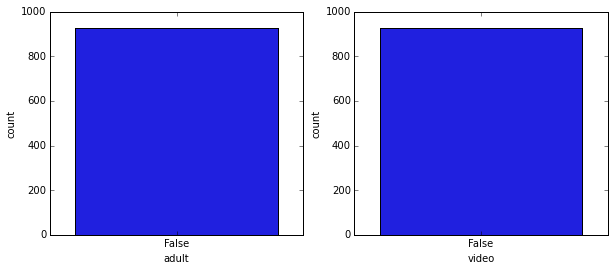

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
sns.countplot(x = 'adult', data=tmdb_movies, ax=ax1)
sns.countplot(x = 'video', data=tmdb_movies, ax=ax2)


#### Time variable

In [77]:
tmdb_movies['release_date'].describe()

count            925
unique           882
top       1916-01-01
freq               5
Name: release_date, dtype: object

In [106]:
tmdb_movies['release_date'] = pd.to_datetime(tmdb_movies['release_date'], coerce=True)

/Users/aixu/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: the coerce=True keyword is deprecated, use errors='coerce' instead
  if __name__ == '__main__':


In [107]:
year = tmdb_movies['release_date'].dt.year

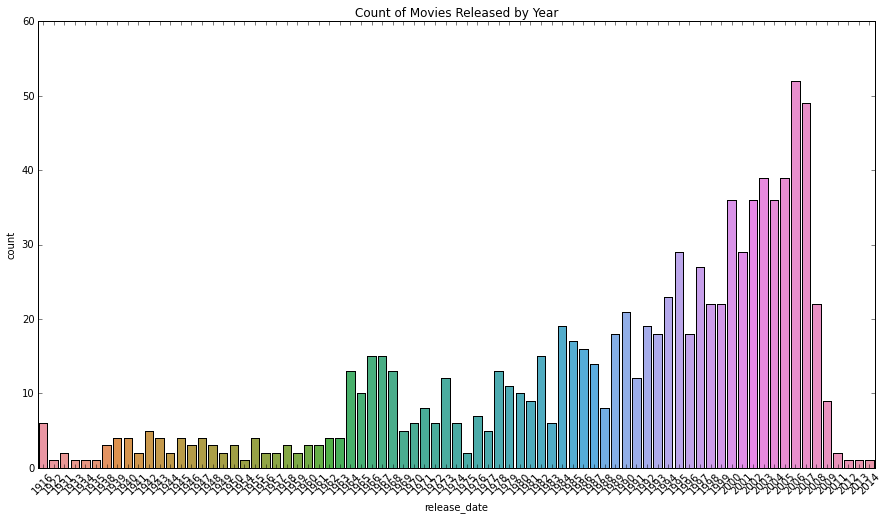

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(15,8))
sns.countplot(x = year, ax=ax)
ax.set_title("Count of Movies Released by Year")
xt = plt.xticks(rotation=45)

### (2) Categorical Features

In [62]:
categorical = tmdb_movies.select_dtypes(include = ['object'])
categorical.columns.values

array([u'backdrop_path', u'belongs_to_collection', u'genres', u'homepage',
       u'imdb_id', u'original_language', u'original_title', u'overview',
       u'poster_path', u'production_companies', u'production_countries',
       u'release_date', u'spoken_languages', u'status', u'tagline',
       u'title'], dtype=object)

In [64]:
categorical.head()

,backdrop_path,belongs_to_collection,genres,homepage,imdb_id,original_language,original_title,overview,poster_path,production_companies,production_countries,release_date,spoken_languages,status,tagline,title
10003,/lJnl8xIhplfzUBtlJLsWBwvXVBj.jpg,The Saint Collection,"[Thriller, Action, Romance, Science Fiction, A...",,tt0120053,en,The Saint,"Ivan Tretiak, Russian Mafia boss who wants to ...",/uA24D8JCg21RDINMZ3vFaQYdIzW.jpg,"[Paramount Pictures, Mace Neufeld Productions,...",[United States of America],1997-04-03,"[English, Pусский]",Released,Never reveal your name. Never turn your back. ...,The Saint
10005,/u7IzK6tISpsSuNkWMowl17gSA4e.jpg,Behind Enemy Lines Collection,"[Action, Adventure, Thriller]",http://www.foxhome.com/behindenemylinesiiaxiso...,tt0497329,en,Behind Enemy Lines II: Axis of Evil,"Navy SEALS, headed by Lt. Bobby James, are dis...",/dw1ArDmyrKgqWYohM6CGEpRMxca.jpg,[Twentieth Century Fox Film Corporation],[United States of America],2006-10-17,"[English, Pусский]",Released,The fate of the world hangs in the balance in ...,Behind Enemy Lines II: Axis of Evil
10007,/l9fdcaqaQQLE2K8cYwfoIPXi0i7.jpg,See No Evil Collection,"[Horror, Thriller]",,tt0437179,en,See No Evil,A group of delinquents are sent to clean the B...,/rZ0YSY6iRhXENygGlNebP9RfZlM.jpg,"[Lions Gate Films, WWE Studios]",[United States of America],2006-05-19,[English],Released,This summer. Evil gets raw.,See No Evil
10009,/fAzT4AboZXP2Sj3zE2HcQ7qjMi.jpg,Brother Bear Collection,"[Adventure, Animation, Family]",http://movies.disney.com/brother-bear,tt0328880,en,Brother Bear,When an impulsive boy named Kenai is magically...,/otptPbEY0vBostmo95xwiiumMJm.jpg,[Walt Disney Feature Animation],[United States of America],2003-10-23,"[Hrvatski, English, ]",Released,Nature Calls,Brother Bear
10010,/zhMiJmPuX2o2bbXWWZNUgVbw3OM.jpg,Brother Bear Collection,"[Adventure, Animation, Family]",http://movies.disney.com/brother-bear-2,tt0465925,en,Brother Bear 2,Kenai finds his childhood human friend Nita an...,/msZSTfilEF6hw47HTuf5AeXAO8R.jpg,[DisneyToon Studios],[United States of America],2006-08-17,[English],Released,,Brother Bear 2


### check missing value

In [68]:
n_missing_categorical = []
for col in categorical:
    n_missing_categorical.append(categorical[col].isnull().values.sum())
missing_categorical=pd.DataFrame({'Features': categorical.columns.values, 'Missing':n_missing_categorical})
print "Number of missing values in both train and test data set"
missing_categorical[missing_categorical['Missing']!=0]

Number of missing values in both train and test data set


,Features,Missing
0,backdrop_path,42
8,poster_path,9


In [97]:
categorical1=categorical[['belongs_to_collection', 'original_language', 'production_companies', 'production_countries', 'spoken_languages', 'status']]

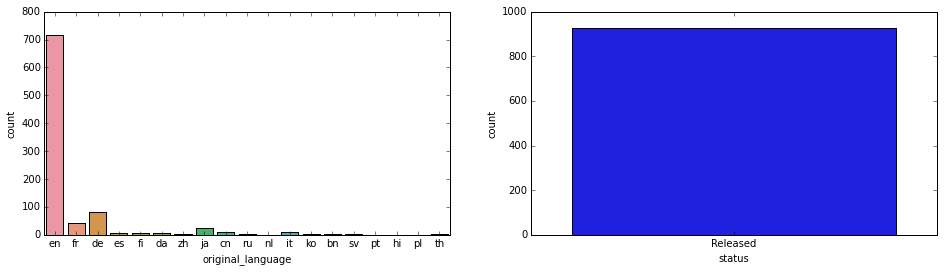

In [96]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (16, 4))
sns.countplot(x = 'original_language', data = categorical, ax=ax1)
sns.countplot(x = 'status', data = categorical, ax=ax2)
plt.show()